In [45]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import dataloader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [34]:
class Discriminator(nn.Module):
    def __init__(self,inch,features):
        super().__init__()
        #((n-f+2p)/s)+1
        self.dis= nn.Sequential(
            nn.Conv2d(inch,features,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self.convblock(features,features*2,kernel_size=4,stride=2,padding=1),
            self.convblock(features*2,features*4,kernel_size=4,stride=2,padding=1),
            self.convblock(features*4,features*8,kernel_size=4,stride=2,padding=1),
            nn.Conv2d(features*8,1,kernel_size=4,stride=2,padding=0),
            nn.Sigmoid()

        )

    def convblock(self,in_channels,out_channels,kernel_size,stride,padding):
        block= nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

        return block

    def forward(self,x):
      return self.dis(x)

class Generator(nn.Module):

    def __init__(self,zdim,otch,features):
        super().__init__()
        #((n-f+2p)/s)+1
        self.enc= nn.Sequential(

            self.convTblock(zdim,features*16,4,1,0),
            self.convTblock(features*16,features*8,4,2,1),
            self.convTblock(features*8,features*4,4,2,1),
            self.convTblock(features*4,features*2,4,2,1),
            nn.ConvTranspose2d(features*2,otch,kernel_size=4,stride=2,padding=1),
            nn.Tanh(),
        )

    def convTblock(self,in_channels,out_channels,kernel_size,stride,padding):
        block= nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        return block

    def forward(self,x):
      return self.enc(x)

In [35]:
def weightsinit(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

In [42]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=2e-4
noisedim=100
imagedim=64
chan=3

features=64
batchsize=128
epochs=5

In [46]:
disc= Discriminator(chan,features).to(device)
gen= Generator(noisedim,chan,features).to(device)

weightsinit(disc)
weightsinit(gen)


opt_disc= optim.Adam(disc.parameters(),lr=lr, betas=(0.5,0.999))
opt_gen= optim.Adam(gen.parameters(),lr=lr, betas=(0.5,0.999))


fixednoise=torch.randn(32,noisedim,1,1).to(device)

transform= transforms.Compose([
    transforms.Resize((imagedim,imagedim)),
    transforms.ToTensor(),
    transforms.Normalize([(0.5) for _ in range(chan)],[(0.5) for _ in range(chan)])
])
dataset= datasets.CIFAR10(root='cifR/',train=True,transform=transform,download=True)
dataloader= torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=True)

criterion= nn.BCELoss()

Files already downloaded and verified


In [47]:
len(dataloader)

391

In [39]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [40]:
from tqdm import tqdm

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
1it [00:00,  1.72it/s, lossD=0.688, lossG=0.807]

Epoch 0 Loss D: 0.0017598391798756008 Loss G: 0.002062794649997331


391it [02:33,  2.54it/s, lossD=0.44, lossG=1.68]
1it [00:00,  2.06it/s, lossD=0.503, lossG=1.69]

Epoch 1 Loss D: 0.18466140849687293 Loss G: 1.1813491437312624


391it [02:32,  2.56it/s, lossD=0.628, lossG=1.37]
1it [00:00,  2.08it/s, lossD=0.563, lossG=1.33]

Epoch 2 Loss D: 0.18450047608023512 Loss G: 0.5508540430743778


391it [02:32,  2.56it/s, lossD=0.711, lossG=0.947]
1it [00:00,  2.09it/s, lossD=0.663, lossG=2.38]

Epoch 3 Loss D: 0.14848198907454604 Loss G: 0.3411282411088114


391it [02:32,  2.56it/s, lossD=0.576, lossG=3.29]
1it [00:00,  2.06it/s, lossD=0.734, lossG=0.77]

Epoch 4 Loss D: 0.10527588897348975 Loss G: 0.3397873529997628


391it [02:32,  2.56it/s, lossD=0.417, lossG=2.31]


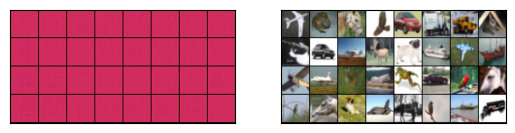

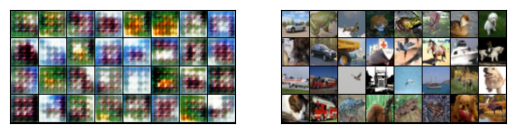

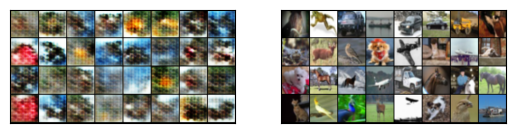

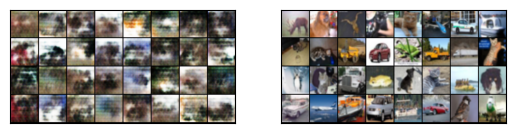

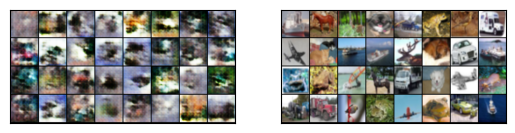

In [48]:
lossDacg=0
lossGacg=0
for epoch in range(epochs):
  loop=tqdm(enumerate(dataloader))

  for (bid,(img,_)) in loop:

    #Discriminator training
    real=img.to(device)
    noise= torch.randn(batchsize,noisedim,1,1).to(device)
    disc_real=disc(real).reshape(-1)
    lossD_real= criterion(disc_real,torch.ones_like(disc_real))

    fake= gen(noise)
    disc_fake=disc(fake).reshape(-1)
    lossD_fake= criterion(disc_fake,torch.zeros_like(disc_fake))


    lossD= (lossD_real+lossD_fake)/2
    lossDacg+=lossD.item()
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    #Generator Training

    out=disc(fake).reshape(-1)
    lossG= criterion(out,torch.ones_like(out))
    lossGacg+=lossG.item()

    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    loop.set_postfix({'lossD': lossD.item(),'lossG': lossG.item()})
    #print(bid)

    if bid==0:
      print(f'Epoch {epoch} Loss D: {lossDacg/((epoch+1) * len(dataloader))} Loss G: {lossGacg/((epoch+1) * len(dataloader))}')
      lossDacg=0
      lossGacg=0

      with torch.no_grad():
        fake=gen(fixednoise)

        img_grid_fake= torchvision.utils.make_grid(fake,normalize=True)
        img_grid_real= torchvision.utils.make_grid(real[:32],normalize=True)

        show([img_grid_fake,img_grid_real])


In [ ]:
torch.save(disc.state_dict(),'disc_DCGAN.pth')
torch.save(gen.state_dict(),'gen_DCGAN.pth')

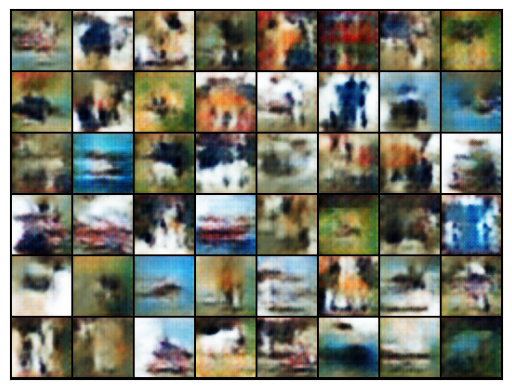

In [49]:
random= torch.randn(48,noisedim,1,1).to(device)
fake= gen(random)
img_grid_fake= torchvision.utils.make_grid(fake,normalize=True)
show(img_grid_fake)